# Transformer

## 注意力提示

In [1]:
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# 注意力的可视化
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5,3.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    for i,(row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax,matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(),cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

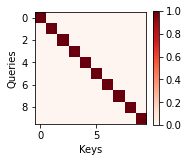

In [3]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 注意力汇聚：Nadaraya-Watson核回归

### 非参数注意层

In [4]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

In [5]:
n_train = 50 # 训练样本
x_train, _ = torch.sort(torch.rand(n_train) * 5)    # 排序后的训练样本

In [6]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5,(n_train,))   # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)    # 测试样本的真实输出
n_test = len(x_test)   # 测试样本数

In [7]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth,label = 'Truth')
    plt.plot(x_test,y_hat, label = 'Pred')
    plt.xlim=[0, 5]
    plt.ylim = [-1,5]
    plt.scatter(x_train, y_train,c='red',alpha=0.5)
    plt.grid(True)
    plt.legend()

```python
torch.repeat_interleave(input, repeats, dim=None) 
```
* 函数功能:沿着指定的维度重复张量的元素

*  输入参数：
    (1）input (类型：torch.Tensor)：输入张量
    (2）repeats（类型：int或torch.Tensor）：每个元素的重复次数
    (3）dim（类型：int）需要重复的维度。默认情况下dim=None，表示将把给定的输入张量展平（flatten）为向量，然后将每个元素重复repeats次，并返回重复后的张量。

* 注意
    (1)如果不指定dim，则默认将输入张量扁平化(维数是1，因此这时repeats必须是一个数，不能是数组)，并且返回一个扁平化的输出数组。
    (2)返回的数组与输入数组维数相同，并且除了给定的维度dim，其他维度大小与输入数组相应维度大小相同
    (3)repeats：如果传入数组，则必须是tensor格式。并且只能是一维数组，数组长度与输入数组input的dim维度大小相同

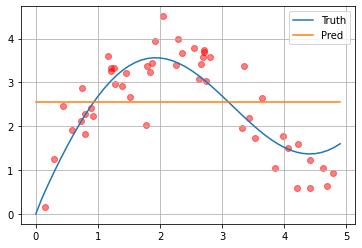

In [8]:
# 如果就是平均汇聚而不在乎输入的x_i
y_hat = torch.repeat_interleave(y_train.mean(), n_test)     # 将y_train.mean重复n_test遍
plot_kernel_reg(y_hat)

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$

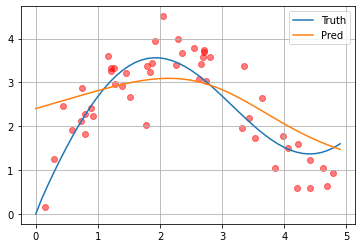

In [9]:
# X_repeat的形状：（n_test,n_train）
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1,n_train))
# X_train包含着键。attention_weights的形状：（n_test,n_train）,
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train) ** 2 / 2,dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

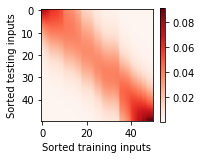

In [10]:
show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel='Sorted training inputs',
              ylabel='Sorted testing inputs')

### 带参数注意力汇聚

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$


批量矩阵乘法
```python
torch.bmm(a,b)
```
a.shape = (n,a,b)
b.shape = (n,b,c)
torch.bmm(a,b).shape = (n,a,c)

kwargs 是 keyword arguments 的缩写，表示关键字参数；

**kwargs 可以接收关键字参数，变成 dict 给函数体调用

```python
repeat_interleave(self: Tensor, repeats: _int, dim: Optional[_int]=None)：
```

self: 传入的数据为tensor

repeats: 复制的份数

dim: 要复制的维度，可设定为0/1/2.....

repeat_interleave()：在原有的tensor上，按每一个tensor复制。

repeat()：根据原有的tensor复制n个，然后拼接在一起。

In [11]:
# 定义模型 使用小批量矩阵乘法，定义Nadaraya-Watson核回归带参数版本
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):  
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))
    
    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为（查询个数，“键-值”对个数）
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries- keys) * self.w)**2/2,dim=1)
        # values的形状为(查询个数，“键-值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1), # .unsqueeze(a),在dim=a上拓展1
                         values.unsqueeze(-1)).reshape(-1)

In [12]:
# 训练
# 训练的时候要把对角线元素去除否则就为0没有意义

# X_title的形状为：(n_train, n_train),每一行包含着相同的训练输入
X_tile = x_train.repeat((n_train,1))
# Y_title的形状为：(n_train, n_train),每一行包含着相同的训练输出
Y_tile = y_train.repeat((n_train,1))
# Keys的形状为：('n_train','n_train'-1)  函数torch.eye(n,m)返回大小为n * m的2-D张量，对角线为1，其他位置为零。
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))
# values的形状为：('n_train','n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train,-1))


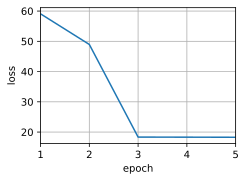

In [13]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction = 'none')   # L2范数惩罚
trainer = torch.optim.SGD(net.parameters(),lr = 0.5)
animator = d2l.Animator(xlabel='epoch',ylabel='loss', xlim=[1,5])

for epoch in range(5):
    trainer.zero_grad()
    l =loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print('epoch{},loss'.format(epoch+1, l.sum()))
    animator.add(epoch+1, float(l.sum()))

tensor.detach()

返回一个新的tensor，从当前计算图中分离下来的，但是仍指向原变量的存放位置,不同之处只是requires_grad为false，得到的这个tensor永远不需要计算其梯度，不具有grad。

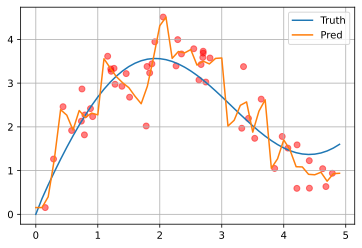

In [14]:
# 预测过程，要把所有的样本都算上不需要把对角线去除
# keys的形状为：(n_test, n_train), 每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# values的形状为:(n_test,n_train)
values = y_train.repeat((n_test,1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

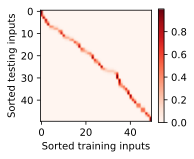

In [15]:
show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
              xlabel = 'Sorted training inputs',
              ylabel = 'Sorted testing inputs')

## 注意力评分函数

In [16]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 遮掩softmax操作

In [60]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项

    Defined in :numref:`sec_seq2seq_decoder`"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    # type(mask)  == bool
    X[~mask] = value
    return X

In [61]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上遮掩元素来执行softmax操作"""
    # X:3D张量 valid_lens:1D或2D张量
    if valid_lens is None:                    # 如果有效长度没有设置，则全部输入进去
        return nn.functional.softmax(X, dim=1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:             # 所有小批次的有效长度一样
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])  # 将valid_len拓展成每一个batcg_size查询的个数
        else:
            valid_lens = valid_lens.reshape(-1) 
        # 最后一轴上被遮掩的元素使用一个非常强大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]),valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [65]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4090, 0.5910, 0.0000, 0.0000],
         [0.4515, 0.5485, 0.0000, 0.0000]],

        [[0.2053, 0.2788, 0.5159, 0.0000],
         [0.3213, 0.3359, 0.3427, 0.0000]]])

In [66]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3351, 0.2676, 0.3974, 0.0000]],

        [[0.5891, 0.4109, 0.0000, 0.0000],
         [0.2488, 0.2682, 0.2327, 0.2504]]])

In [62]:
valid_lens = torch.tensor([1,2,3])
valid_lens = torch.repeat_interleave(valid_lens, 2)
valid_lens

tensor([1, 1, 2, 2, 3, 3])

### 加性注意力

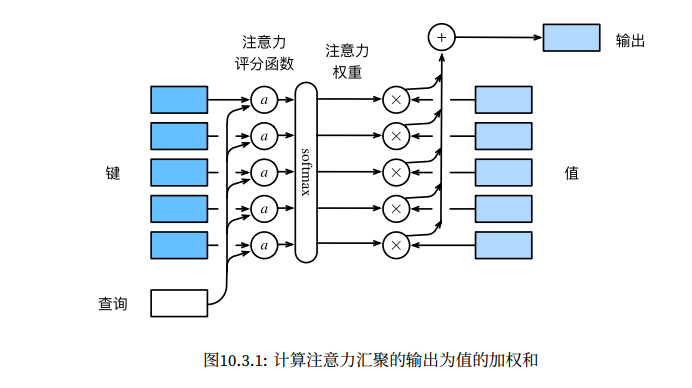

一般来说，当查询和键是不同长度的矢量时，我们可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和键$\mathbf{k} \in \mathbb{R}^k$，*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、$\mathbf W_k\in\mathbb R^{h\times k}$和$\mathbf w_v\in\mathbb R^{h}$。将查询和键连结起来后输入到一个多层感知机（MLP）中，感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。通过使用$\tanh$作为激活函数，并且禁用偏置项。

In [95]:
# 查询、键和值的形状为（批量⼤⼩，步数或词元序列⻓度，特征⼤⼩）
# 注意⼒汇聚输出的形状为（批量⼤⼩，查询的步数，值的维度）

class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后
        # queries的形状：（batch_size, 查询个数， 1， num_hiddens）
        # key的形状：（batch_size,1,"键-值"对的个数, num_hiddens）
        # 使用广播方式求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)    # unsqueeze() 扩展维度
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度
        # scores的形状：（batch_size,查询的个数，“键-值”对的个数）
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)    # masked_softmax包括了遮掩和softmax两个操作
        # values的形状：(batch_size, "键-值"对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights),values) # （batch_size,查询的个数，值的维度）

In [96]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的⼩批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

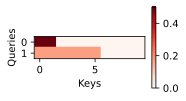

In [97]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
xlabel='Keys', ylabel='Queries')

### 缩放点积注意力
查询和键的所有元素都是独⽴的随机变量，并且都满⾜零均值和单位⽅差，那么两个向量的点积的均值为0，⽅差为d为确保⽆论向量⻓度如何，点积的⽅差在不考虑向量⻓度的情况下仍然是1，我们将点积除以pd，则缩放点积注意⼒（scaled dot-product attention）评分函数为
$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，例如基于$n$个查询和$m$个键－值对计算注意力，其中查询和键的长度为$d$，值的长度为$v$。查询$\mathbf Q\in\mathbb R^{n\times d}$、键$\mathbf K\in\mathbb R^{m\times d}$和值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$

In [98]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        
    # queries的形状为：（batch_size,查询的个数，d）
    # keys的形状为：（batch_size,"键-值"对的个数，d）
    # values的形状为：(batch_size,)或者(batch_size, 查询的个数)
    # valid_lens的形状为:(batch_size,) 或者（batch_size, 查询的个数）
    def forward(self, queries, keys, values, valid_len=None):
        d = queries.shape[-1]
        # 设置transpose_b = True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights),values)

In [99]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

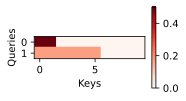

In [100]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
xlabel='Keys', ylabel='Queries')

## Bahdanau注意力

In [27]:
import torch
from torch import nn
from d2l import torch as d2l

In [28]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制编码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
        
    @property
    def attetntion_weights(self):
        raise NotImplementedError

In [29]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)

In [30]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size, num_steps, num_hiddens)
        # hidden_state的形状为(num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1,0,2), hidden_state, enc_valid_lens)
    
    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens)
        # hidden_state的形状为(num_layers,batch_size,num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连接
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim = -1)
            # 将x变形为(1, batch_size, embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1,0,2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后,outputs的形状为(num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1,0,2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [31]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.020, 6669.6 tokens/sec on cpu


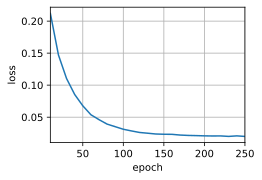

In [32]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab),embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [33]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est mouillé .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


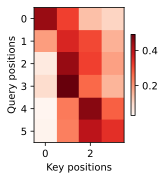

In [20]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq],0).reshape((1, 1, -1, num_steps))
d2l.show_heatmaps(attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),xlabel='Key positions', ylabel='Query positions')

## 多头注意力
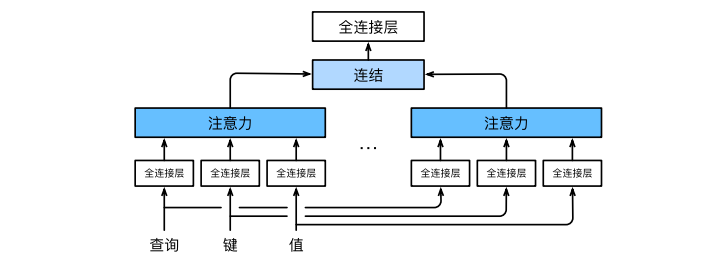

In [20]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [21]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # queries, keys, values的形状为
        # (batch_size, 查询或者"键-值"对的个数， num_hiddens)
        # valid_lens的形状为(batch_size, ) 或(batch_size, 查询的个数)
        # 经过变换后，输出的queries， keys, values 的形状:
        # (batch_size*num_heads, 查询或者"键-值"对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            # 在轴0,将第一项(标量或者矢量)复制num_heads次
            # 然后如此复制第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
            
        # output的形状:(batch_size*num_heads, 查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # output_concat的形状为:(batch_size,查询的个数， num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [22]:
# 转置函数
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size, 查询或者"键-值"对的个数， num_hiddens)
    # 输出x的形状:(batch_size, 查询或者"键-值"对的个数， num_heads,num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1],num_heads,-1)
    
    # 输出X的形状:(batch_size, num_heads, 查询或者"键-值"对的个数，num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    
    # 最终输出的形状:(batch_size*num_heads,查询或者“键-值”对的个数，num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2],X.shape[3])

def transpose_output(X, num_heads):
    """逆转Transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [23]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [24]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## 自注意力和位置编码